In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

import matplotlib.pyplot as plt

#Load the compact dataset
df = pd.read_parquet("mushroom_compact.parquet", engine="fastparquet")

cols_to_drop = [
    "cap-surface",
    "gill-attachment",
    "gill-spacing",
    "stem-root",
    "stem-surface",
    "veil-type",
    "veil-color",
    "spore-print-color",
]
df_model = df.drop(columns=cols_to_drop).copy()

#Feature lists
numeric_features = ["cap-diameter", "stem-height", "stem-width"]

categorical_features = [
    "stem-color",
    "cap-color",
    "ring-type",
    "gill-color",
    "habitat",
    "cap-shape",
    "season",
    "has-ring",
    "does-bruise-or-bleed",
]
df_model["class_binary"] = df_model["class"].map({"e": 1, "p":0})
#Target
target_col = "class_binary"

In [17]:
df_model.columns.tolist()

['class',
 'cap-diameter',
 'cap-shape',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-color',
 'has-ring',
 'ring-type',
 'habitat',
 'season',
 'class_binary']

In [18]:
#train test split
X = df_model[numeric_features + categorical_features]
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape


((5378492, 12), (1344624, 12))

In [19]:
#preprocessing and pipeline for random forest
# Preprocessing for Random Forest

numeric_transformer_rf = "passthrough"

categorical_transformer_rf = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_features),
        ("cat", categorical_transformer_rf, categorical_features),], remainder="drop")

#random Forest model
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample")  #helps if classes are imbalanced
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_rf),
        ("model", rf_clf),])



In [20]:
#fit the model
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['stem-color', 'cap-color',
                                                   'ring-type', 'gill-color',
                                                   'habitat', 'cap-shape',
                                                   'season', 'has-ring',
                                                   'does-bruise-or-bleed'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [21]:
#predictions
y_pred = rf_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9982270136484251

Confusion matrix:
 [[734823   1214]
 [  1170 607417]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    736037
           1       1.00      1.00      1.00    608587

    accuracy                           1.00   1344624
   macro avg       1.00      1.00      1.00   1344624
weighted avg       1.00      1.00      1.00   1344624



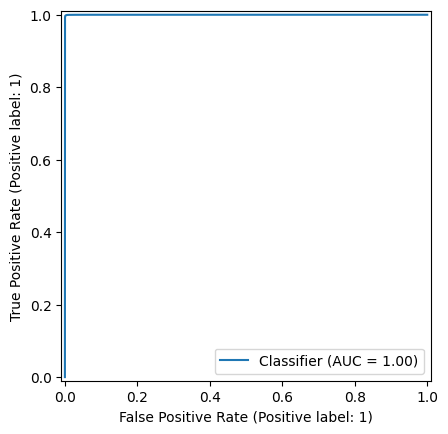

In [22]:
#roc curve
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()


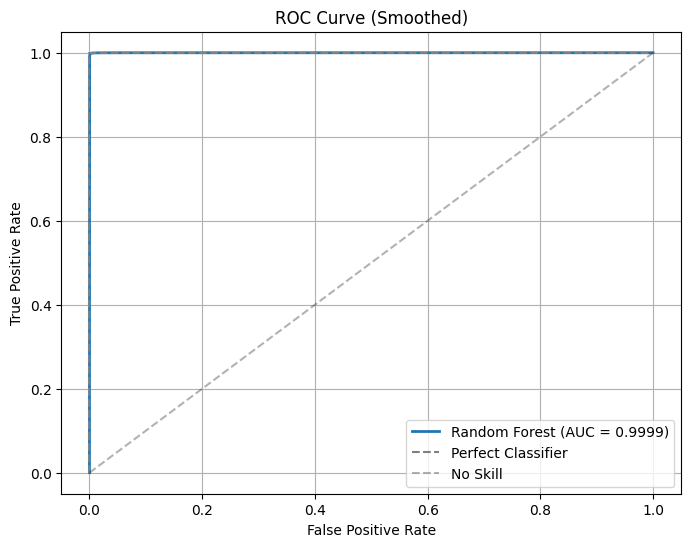

In [23]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for positive class
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

# Compute FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, label=f"Random Forest (AUC = {roc_auc:.4f})")
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', color='gray', label="Perfect Classifier")
plt.plot([0,1], [0,1], linestyle='--', color='black', alpha=0.3, label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()


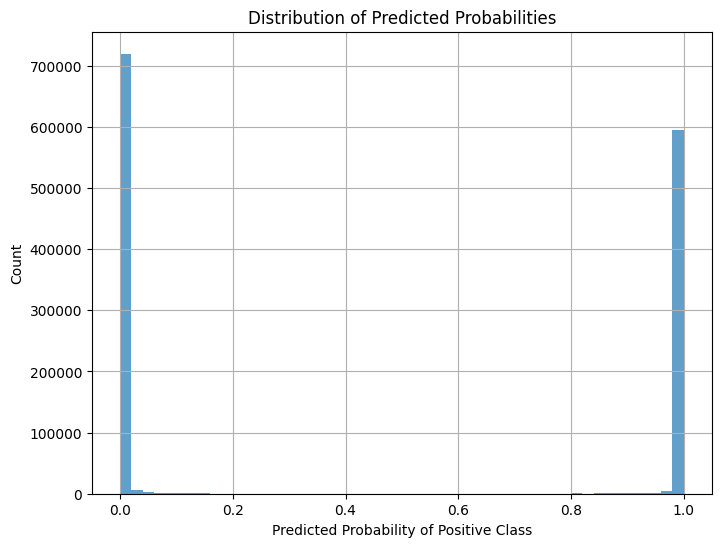

In [24]:
#examine predicted probabilities
plt.figure(figsize=(8,6))
plt.hist(y_proba, bins=50, alpha=0.7)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability of Positive Class")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [25]:
# Pull out the trained RandomForest model
rf_model = rf_pipeline.named_steps["model"]

# Get feature names after preprocessing
# Numeric first, then categorical labels encoded ordinally
feature_names = numeric_features + categorical_features

# Importances
importances = rf_model.feature_importances_

# Create a DataFrame for easy viewing
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi_df


,feature,importance
2,stem-width,0.160950
6,gill-color,0.117217
1,stem-height,0.111509
3,stem-color,0.104140
0,cap-diameter,0.099285
4,cap-color,0.095715
8,cap-shape,0.083770
5,ring-type,0.079701
7,habitat,0.047978
11,does-bruise-or-bleed,0.045573


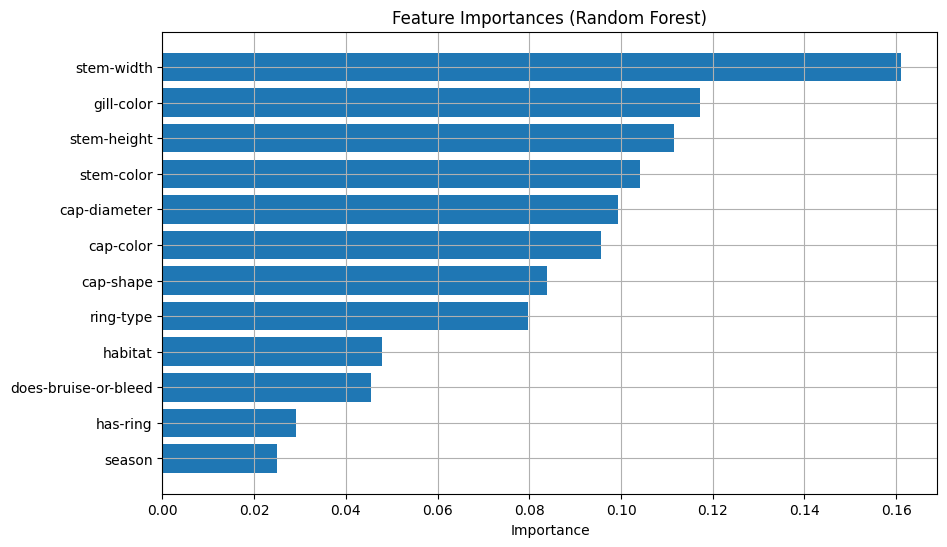

In [26]:
#plot feature importance
plt.figure(figsize=(10,6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()
